# Modeling

In [10]:
filepath = 'C:/Users/Tim/Desktop/lighthouse/w11,12 - final project/'
data_filepath = filepath + 'data/'
final_data = 'final_df.csv'

import pandas as pd
import numpy as np
import copy
import seaborn as sns

In [11]:
df = pd.read_csv(data_filepath + final_data)
df.head()

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,...,team_rank,kdr,kpr,n_impact,performance,rank_differential,rank_weight,w_performance,perf_resid,perf_resid_lag
0,s1mple,2020-02-29,Natus Vincere,16,Astralis,5,nuke,18,11,7,...,6,1.636364,0.857143,0.330758,1.850758,-5,1.5,2.776137,1.256137,1.256137
1,s1mple,2020-02-29,Natus Vincere,16,Astralis,5,d2,25,11,14,...,6,2.272727,1.190476,0.330758,2.420758,-5,1.5,3.631137,1.541137,1.256137
2,electronic,2020-02-29,Natus Vincere,16,Astralis,5,nuke,22,5,17,...,6,4.400000,1.047619,0.165008,2.025008,-5,1.5,3.037512,1.177512,1.177512
3,electronic,2020-02-29,Natus Vincere,16,Astralis,5,d2,15,11,4,...,6,1.363636,0.714286,0.165008,1.325008,-5,1.5,1.987512,0.827512,1.177512
4,flamie,2020-02-29,Natus Vincere,16,Astralis,5,nuke,23,10,13,...,6,2.300000,1.095238,-0.036592,1.753408,-5,1.5,2.630112,0.840112,0.840112


In [12]:
df['date'] = pd.to_datetime(df.date)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df = df[df['team']!='Sprout']

In [13]:
drop=[# 'target',
#       'opposing_team',
      'player',
      'date',
#       'kills',
#       'deaths',
#       'kdr',
#       'kpr',
#       'mean_team_kdr',
#       'mean_team_kpr',
#       'w_performance',
#       'perf_resid_lag',
#       'perf_resid',
#       'n_impact',
#       'rank_weight',
#       'team_rank',
#       'opposing_team_rank',
#       'p_rounds_won',
#       'opening_duels',
#       'multi_kills',
#       'avg_impact',
#       'differential',
#       'rating',
      'team_rounds',
      'opposing_team_rounds'
]
df = df.drop(columns=drop)

## Neural Network

In [15]:
# try knn, svm, log reg, random forest, xgboost
from numpy import sort
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn import metrics

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [82]:
X = df.drop(columns = 'target')
y = df['target']

x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=123)

In [16]:
# https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

val_dataframe = df.sample(frac=0.3, random_state=123)
train_dataframe = df.drop(val_dataframe.index)
print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 19805 samples for training and 8488 for validation


In [78]:
# tensorflow dataset
def dataframe_to_dataset(dataframe):
    dataframe = df.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds_ = dataframe_to_dataset(train_dataframe)
val_ds_ = dataframe_to_dataset(val_dataframe)

In [79]:
# batching
train_ds = train_ds_.batch(32)
val_ds = val_ds_.batch(32)

In [22]:
# categorical string features - use stringlookup() then categoryencoding()
# map, team, opposing team
# the rest are continuous features - use normalization() layer
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [23]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature

In [24]:
[i for i in df.columns]

['team',
 'opposing_team',
 'map',
 'kills',
 'deaths',
 'differential',
 'rating',
 'avg_impact',
 'p_rounds_won',
 'opening_duels',
 'multi_kills',
 'team_5v4',
 'team_4v5',
 'team_traded',
 'utility_adr',
 'utility_flash',
 'target',
 'opposing_team_rank',
 'team_rank',
 'kdr',
 'kpr',
 'n_impact',
 'performance',
 'rank_differential',
 'rank_weight',
 'w_performance',
 'perf_resid',
 'perf_resid_lag']

In [25]:
# Categorical feature encoded as string
map_ = keras.Input(shape=(1,), name="map", dtype="string")
team = keras.Input(shape=(1,), name="team", dtype="string")
o_team = keras.Input(shape=(1,), name="opposing_team", dtype="string")
# Numerical features
kills = keras.Input(shape=(1,), name="kills")
deaths = keras.Input(shape=(1,), name="deaths")
differential = keras.Input(shape=(1,), name="differential")
rating = keras.Input(shape=(1,), name="rating")
avg_impact = keras.Input(shape=(1,), name="avg_impact")
p_rounds_won = keras.Input(shape=(1,), name="p_rounds_won")
opening_duels = keras.Input(shape=(1,), name="opening_duels")
multi_kills = keras.Input(shape=(1,), name="multi_kills")
team_5v4 = keras.Input(shape=(1,), name="team_5v4")
team_4v5 = keras.Input(shape=(1,), name="team_4v5")
team_traded = keras.Input(shape=(1,), name="team_traded")
utility_adr = keras.Input(shape=(1,), name="utility_adr")
utility_flash = keras.Input(shape=(1,), name="utility_flash")
opposing_team_rank = keras.Input(shape=(1,), name="opposing_team_rank")
team_rank = keras.Input(shape=(1,), name="team_rank")
kdr = keras.Input(shape=(1,), name="kdr")
kpr = keras.Input(shape=(1,), name="kpr")
n_impact = keras.Input(shape=(1,), name="n_impact")
performance = keras.Input(shape=(1,), name="performance")
rank_differential = keras.Input(shape=(1,), name="rank_differential")
rank_weight = keras.Input(shape=(1,), name="rank_weight")
w_performance = keras.Input(shape=(1,), name="w_performance")
perf_resid = keras.Input(shape=(1,), name="perf_resid")
perf_resid_lag = keras.Input(shape=(1,), name="perf_resid_lag")

In [26]:
all_inputs = [
    map_,
    team,
    o_team,
    kills,
    deaths,
    differential,
    rating,
    avg_impact,
    p_rounds_won,
    opening_duels,
    multi_kills,
    team_5v4,
    team_4v5,
    team_traded,
    utility_adr,
    utility_flash,
    opposing_team_rank,
    team_rank,
    kdr,
    kpr,
    n_impact,
    performance,
    rank_differential,
    rank_weight,
    w_performance,
    perf_resid,
    perf_resid_lag
]

# String categorical features
map_encoded = encode_string_categorical_feature(map_, "map", train_ds)
team_encoded = encode_string_categorical_feature(team, "team", train_ds)
o_team_encoded = encode_string_categorical_feature(o_team, "opposing_team", train_ds)

# Numerical features
kills_encoded = encode_numerical_feature(kills, "kills", train_ds)
deaths_encoded = encode_numerical_feature(deaths, "deaths", train_ds)
differential_encoded = encode_numerical_feature(differential, "differential", train_ds)
rating_encoded = encode_numerical_feature(rating, "rating", train_ds)
avg_impact_encoded = encode_numerical_feature(avg_impact, "avg_impact", train_ds)
p_rounds_won_encoded = encode_numerical_feature(p_rounds_won, "p_rounds_won", train_ds)
opening_duels_encoded = encode_numerical_feature(opening_duels, "opening_duels", train_ds)
multi_kills_encoded = encode_numerical_feature(multi_kills, "multi_kills", train_ds)
team_5v4_encoded = encode_numerical_feature(team_5v4, "team_5v4", train_ds)
team_4v5_encoded = encode_numerical_feature(team_4v5, "team_4v5", train_ds)
team_traded_encoded = encode_numerical_feature(team_traded, "team_traded", train_ds)
utility_adr_encoded = encode_numerical_feature(utility_adr, "utility_adr", train_ds)
utility_flash_encoded = encode_numerical_feature(utility_flash, "utility_flash", train_ds)
opposing_team_rank_encoded = encode_numerical_feature(opposing_team_rank, "opposing_team_rank", train_ds)
team_rank_encoded = encode_numerical_feature(team_rank, "team_rank", train_ds)
kdr_encoded = encode_numerical_feature(kdr, "kdr", train_ds)
kpr_encoded = encode_numerical_feature(kpr, "kpr", train_ds)
n_impact_encoded = encode_numerical_feature(n_impact, "n_impact", train_ds)
performance_encoded = encode_numerical_feature(performance, "performance", train_ds)
rank_differential_encoded = encode_numerical_feature(rank_differential, "rank_differential", train_ds)
rank_weight_encoded = encode_numerical_feature(rank_weight, "rank_weight", train_ds)
w_performance_encoded = encode_numerical_feature(w_performance, "w_performance", train_ds)
perf_resid_encoded = encode_numerical_feature(perf_resid, "perf_resid", train_ds)
perf_resid_lag_encoded = encode_numerical_feature(perf_resid_lag, "perf_resid_lag", train_ds)

In [30]:
all_features = layers.concatenate(
    [
        map_encoded,
        team_encoded,
        o_team_encoded,
        kills_encoded,
        deaths_encoded,
        differential_encoded,
        rating_encoded,
        avg_impact_encoded,
        p_rounds_won_encoded,
        opening_duels_encoded,
        multi_kills_encoded,
        team_5v4_encoded,
        team_4v5_encoded,
        team_traded_encoded,
        utility_adr_encoded,
        utility_flash_encoded,
        opposing_team_rank_encoded,
        team_rank_encoded,
        kdr_encoded,
        kpr_encoded,
        n_impact_encoded,
        performance_encoded,
        rank_differential_encoded,
        rank_weight_encoded,
        w_performance_encoded,
        perf_resid_encoded,
        perf_resid_lag_encoded
    ]
)

x = layers.Dense(64, activation='relu')(all_features)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(all_inputs,output)
model.compile('adam','binary_crossentropy',metrics=['accuracy'])

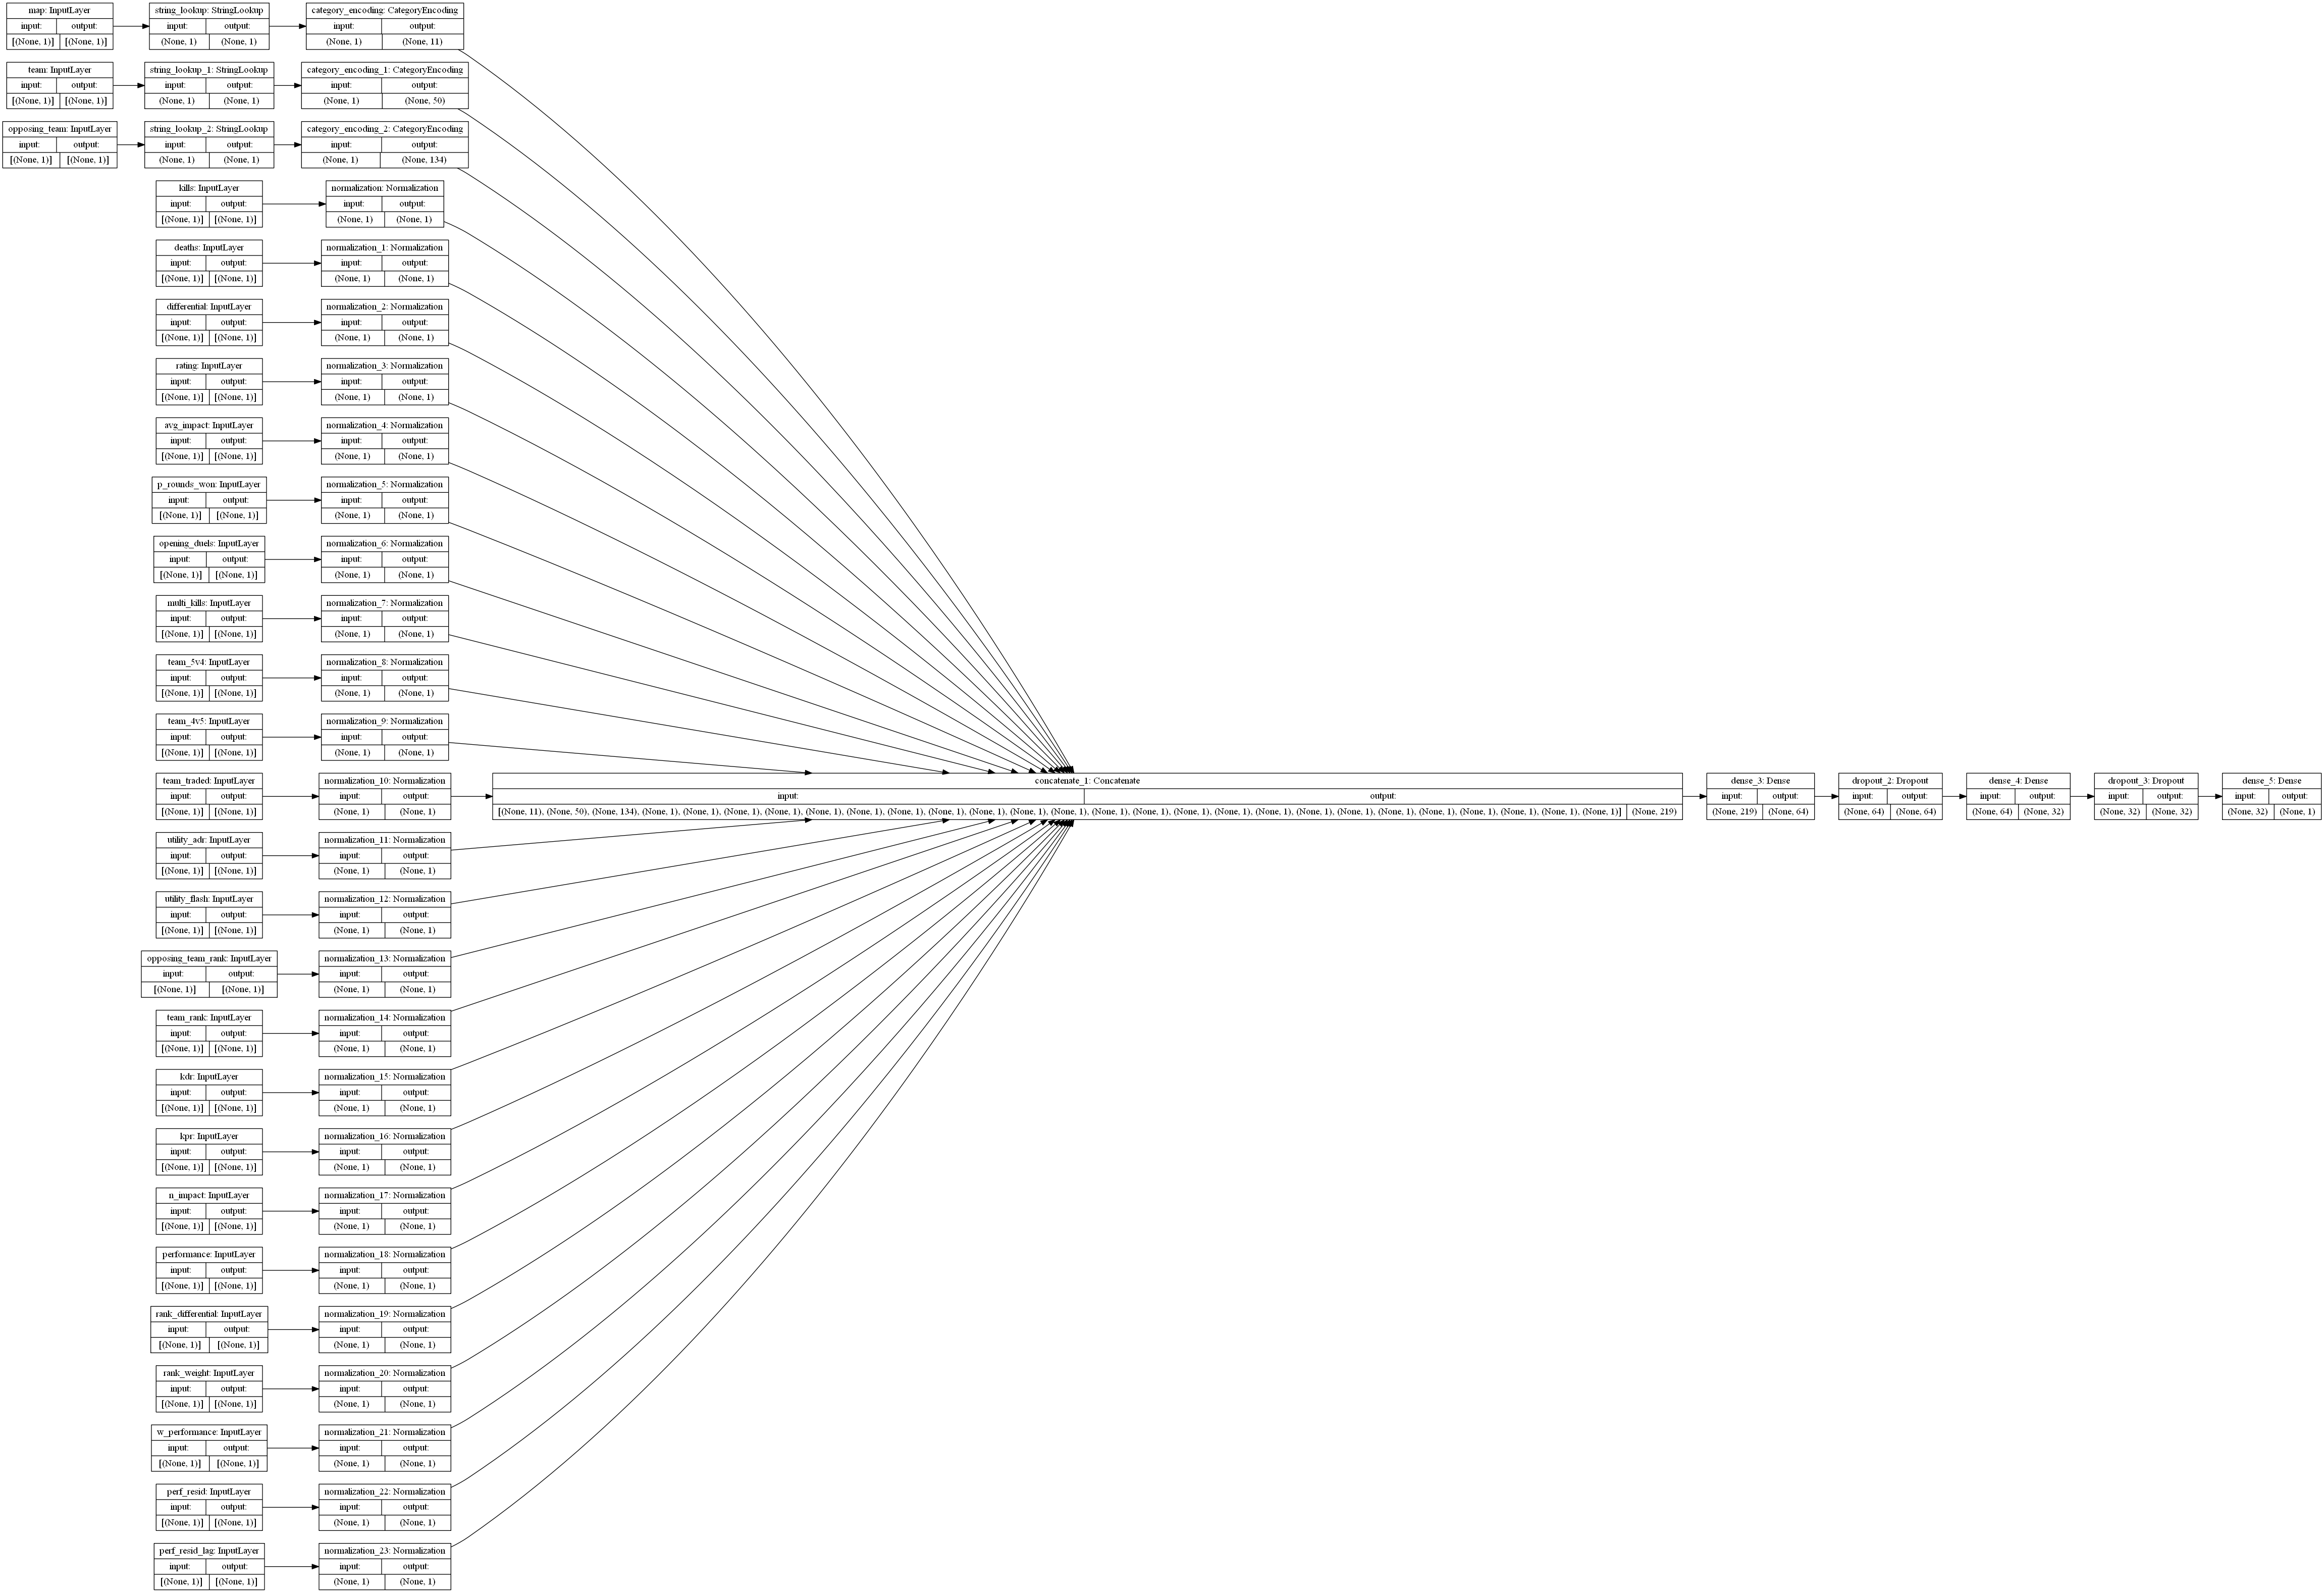

In [34]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [33]:
model.fit(train_ds, epochs=200, validation_data=val_ds)

Epoch 1/200
885/885 [==============================] - 7s 5ms/step - loss: 0.4890 - accuracy: 0.7460 - val_loss: 0.3701 - val_accuracy: 0.8214
Epoch 2/200
885/885 [==============================] - 4s 5ms/step - loss: 0.3777 - accuracy: 0.8184 - val_loss: 0.3466 - val_accuracy: 0.8362
Epoch 3/200
885/885 [==============================] - 4s 5ms/step - loss: 0.3648 - accuracy: 0.8237 - val_loss: 0.3333 - val_accuracy: 0.8426
Epoch 4/200
885/885 [==============================] - 6s 7ms/step - loss: 0.3440 - accuracy: 0.8350 - val_loss: 0.3261 - val_accuracy: 0.8487
Epoch 5/200
885/885 [==============================] - 6s 7ms/step - loss: 0.3421 - accuracy: 0.8392 - val_loss: 0.3140 - val_accuracy: 0.8561
Epoch 6/200
885/885 [==============================] - 5s 6ms/step - loss: 0.3342 - accuracy: 0.8454 - val_loss: 0.3043 - val_accuracy: 0.8636
Epoch 7/200
885/885 [==============================] - 6s 6ms/step - loss: 0.3206 - accuracy: 0.8528 - val_loss: 0.2944 - val_accuracy: 0.8692

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
map (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
team (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
opposing_team (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 1)            0           map[0][0]                        
____________________________________________________________________________________________

In [ ]:
sample = {
    # sample inputs
    
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

In [ ]:
import pickle

with open('best_mlp_model.pickle','wb') as f:
    pickle.dump(model,f)

In [14]:
# # dont have to do a lot of feature processing since nn does it, just use the whole dataset
# drop=['target',
# #       'opposing_team',
#       'player',
# #       'date',
# #       'kills',
# #       'deaths',
# #       'kdr',
# #       'kpr',
# #       'mean_team_kdr',
# #       'mean_team_kpr',
# #       'w_performance',
# #       'perf_resid_lag',
# #       'perf_resid',
# #       'n_impact',
# #       'rank_weight',
# #       'team_rank',
# #       'opposing_team_rank',
# #       'p_rounds_won',
# #       'opening_duels',
# #       'multi_kills',
# #       'avg_impact',
# #       'differential',
# #       'rating',
#       'team_rounds',
#       'opposing_team_rounds'
# ]

# # data = df[features]
# X = df.drop(columns=drop)
# y = df['target']
# X = pd.get_dummies(X)

# x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=123)

In [15]:
# numerical = list(X.dtypes[X.dtypes != 'object'].index)

# categorical = list(X.dtypes[X.dtypes == 'object'].index)

In [ ]:
# from tensorflow.keras.models import Sequential        # Helper to build a network from a sequence of layers
# from tensorflow.keras.layers import Dense             # Fully-connected layer
# from tensorflow.keras.callbacks import EarlyStopping  # To stop training early if val loss stops decreasing

In [ ]:
# model = Sequential()
# model.add(Dense(10, activation='relu', input_shape=(X.shape[1],)))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1))

# # Train the model
# model.compile("adam", "binary_crossentropy", metrics=["accuracy"])    # Builds the static computation graph
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=32, 
#           callbacks=[EarlyStopping(patience=3)], verbose=1)